In [1]:
%load_ext autoreload
%autoreload 2

### imports and utilities

In [2]:
from collections import Counter

from utils import *
from word_network import WordNetwork

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy.special import softmax
from scipy.stats import norm
from scipy.stats import entropy as calculate_entropy


from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.datasets import fetch_20newsgroups
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In c:\program files\python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In c:\program files\python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In c:\program files\python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


### load dataset

In [3]:
# total number of samples needed
randomize = False

# retrieve dataset
categories = ['rec.autos', 'talk.politics.mideast', 'alt.atheism', 'sci.space']

docs = fetch_20newsgroups(subset='train', shuffle=randomize, remove=('headers', 'footers', 'quotes'), categories=categories)
docs, old_labels, classes = docs.data, docs.target, docs.target_names

### clean dataset

In [4]:
datasize = 100
max_document_length = None

index = -1
train_docs, labels = [], []

sizes = [0]*len(categories)

with tqdm(total=len(categories)*datasize) as pbar:
    while sum(sizes) != len(categories)*datasize:
        index += 1
        size_index = categories.index(classes[old_labels[index]])
        
        if sizes[size_index] == datasize:
            continue
        
        doc = docs[index]
        status, doc, word_count = clean_doc(doc, True)
        
        if (not status) or (max_document_length is not None and len(doc) > max_document_length):
            continue
        
        labels.append(categories[size_index])
        train_docs.append(doc)
        sizes[size_index] += 1
        pbar.update(1)

labels = np.array(labels)

In [5]:
index = 0
print(f"Topic: {labels[index]}\n{'='*50}\n{train_docs[index]}")

Topic: alt.atheism
i think that domestication will change behavior to a large degree domesticate animal exhibit behavior not found in the wild i don t think that they can be view a good representative of the wild animal kingdom since they have be breed for thousand of year to produce certain behavior etc


In [6]:
print(sizes)
assert min(sizes) == max(sizes) == datasize

[100, 100, 100, 100]


In [7]:
print(f"there are {len(train_docs)} docs")

there are 400 docs


### Initialize Vectorizer

In [8]:
# initialize the count vectorizer
vectorizer = CountVectorizer()

# fit it to dataset
vectorizer.fit(train_docs)

vocabulary = vectorizer.get_feature_names()
print("word_count is", len(vocabulary))

word_count is 9116


### Prepare Datatset

In [9]:
# create doc count vectors
train_doc_vectors = vectorizer.transform(train_docs).toarray()

total_num_of_documents = len(train_doc_vectors)
print(f"{total_num_of_documents} train_docs")

400 train_docs


### Word-Word Ratio

In [10]:
# reduce freq in doc to bin value of 1 or 0
word_freq_in_doc = pd.DataFrame(train_doc_vectors, columns=vocabulary)
word_word_co = pd.DataFrame(data=0.0, columns=vocabulary, index=vocabulary)

word_doc_frequency = (word_freq_in_doc > 0).astype(int)
probability = word_doc_frequency.sum(0) / len(train_doc_vectors)

for word in tqdm(vocabulary):
    pxy = word_doc_frequency[word_doc_frequency[word] == 1].sum(0) / total_num_of_documents
#     word_word_co[word] = pxy / (probability[word] * probability)
#     word_word_co[word][word_word_co[word] > 0] = word_word_co[word][word_word_co[word] > 0]**-1
    word_word_co[word] = np.nan_to_num(sigmoid(np.nan_to_num(np.log2(pxy / (probability[word] * probability)))))

# word_word_co = (word_word_co.T / word_word_co.sum(1)).T
print(f"word_word_co has shape {word_word_co.shape}")

c:\program files\python37\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\christian\Documents\christian\work\python\cyberspace\semantic_segmentation\utils.py:15: RuntimeWarning: overflow encountered in power
  return 1 / (1 + (np.e**-x))



word_word_co has shape (9116, 9116)


In [11]:
word_word_co.head()

,000,000th,0029,007,01,011,0119,013,02,0245,...,zillion,zimogliad,ziona,zionism,zionist,zman,zone,zoo,zulu,zur
000,0.990471,0.000000,0.000000,0.990471,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.990471,0.0,0.0,0.886843,0.990471,0.0,0.0,0.0,0.0
000th,0.000000,0.999824,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
0029,0.000000,0.000000,0.999824,0.000000,0.999141,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
007,0.990471,0.000000,0.000000,0.999824,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.999824,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
01,0.000000,0.000000,0.999141,0.000000,0.999141,0.0,0.0,0.0,0.0,0.999141,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


### Calculate Word Trust ratio

In [12]:
word_entropy = pd.DataFrame(data=np.nan_to_num(calculate_entropy(word_word_co.T, base=2)), columns=[0], index=vocabulary)[0]
word_trust_factor = pd.DataFrame(data=gaussian(abs(word_entropy - word_entropy.mean())), columns=[0], index=vocabulary)[0]
word_trust_factor = word_trust_factor / word_trust_factor.max()

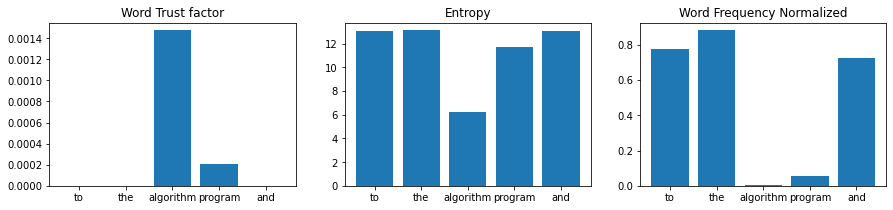

In [13]:
words = ["to", "the", "algorithm", "program", "and"]
# words = np.array(vocabulary)[np.random.randint(len(vocabulary), size=5)]

fig = plt.figure(figsize=(15,3))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title(f"Word Trust factor")
ax1.bar(words, word_trust_factor[words])

ax2.set_title(f"Entropy")
ax2.bar(words, word_entropy[words])

ax3.set_title(f"Word Frequency Normalized")
ax3.bar(words, probability[words])

plt.show()

### Observe word_word_co ratios

In [14]:
wwc = (word_word_co * word_trust_factor)

=== Ploting software against ['to', 'the', 'algorithm', 'program', 'and'] ===


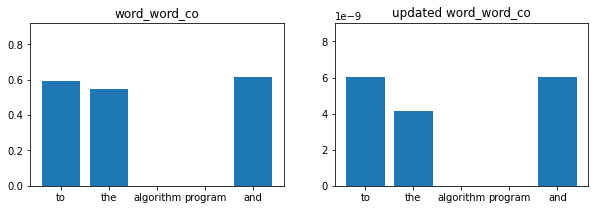

In [15]:
word = "software"

fig = plt.figure(figsize=(10,3))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

print(f"=== Ploting {word} against {words} ===")

values = word_word_co.loc[word][words]
ax1.set_title(f"word_word_co")
ax1.set_ylim(0, 1.5*values.max())
ax1.bar(words, values)

values = wwc.loc[word][words]
ax2.set_title(f"updated word_word_co")
ax2.set_ylim(0, 1.5*values.max())
ax2.bar(words, values)

plt.show()

In [16]:
wwc.loc["war"].sort_values(ascending=False).head(10)

racial         0.985954
ii             0.977344
prior          0.973940
possession     0.973940
supporter      0.972309
fighter        0.969148
ownership      0.967894
espionage      0.965894
revisionist    0.962728
sdpa           0.962692
Name: war, dtype: float64

In [17]:
word_word_co.loc["war"].sort_values(ascending=False).head(10)

zur                  0.985958
interestingly        0.985958
inhumane             0.985958
ingredient           0.985958
chancy               0.985958
sergey               0.985958
turbocharger         0.985958
ineffective          0.985958
indoors              0.985958
indistinguishable    0.985958
Name: war, dtype: float64

In [18]:
word_word_co = wwc

### Update word_word_co with word_word_co

In [19]:
doc_word_distr = word_doc_frequency * word_trust_factor
# doc_word_distr = (doc_word_distr.T / doc_word_distr.sum(1)).T.fillna(0)

In [20]:
doc_index = 13
word_doc_frequency.iloc[doc_index].sort_values(ascending=False).head(10)

directly     1
of           1
didn         1
10           1
maybe        1
his          1
missile      1
get          1
kill         1
operation    1
Name: 13, dtype: int32

In [21]:
doc_word_distr.iloc[doc_index].sort_values(ascending=False).head(10)

surgical     0.471433
directly     0.124246
missile      0.033719
operation    0.004006
body         0.001636
hit          0.001438
destroy      0.001005
someone      0.000783
house        0.000757
course       0.000725
Name: 13, dtype: float64

In [22]:
print(f"Topic: {labels[doc_index]}\n{'='*50}\n{train_docs[doc_index]}")

Topic: talk.politics.mideast
maybe the missile didn t hit directly such that his body get desintegrated of course destroy 10 house to kill someone be not a surgical operation or be it


In [23]:
doc_word_distr.head()

,000,000th,0029,007,01,011,0119,013,02,0245,...,zillion,zimogliad,ziona,zionism,zionist,zman,zone,zoo,zulu,zur
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
for di in range(len(doc_word_distr.index)):
    print(doc_word_distr.iloc[di].sort_values(ascending=False).head(5).index.to_list())
    break

['wild', 'exhibit', 'kingdom', 'animal', 'produce']


### Define Latent partitions

In [241]:
# reduction = None
# reduction = "pca"
reduction = "normal"

if reduction is None:
    columns = doc_word_distr.columns
    param_values = doc_word_distr.values

if reduction == "pca":
    num_of_components = 8
    columns = list(range(num_of_components))
    
    pca = PCA(n_components=num_of_components)
    param_values = pca.fit_transform(doc_word_distr)

if reduction == "normal":
    columns = ["mean", "std"]
    column_values = [doc_word_distr.mean(1), doc_word_distr.std(1)]
    param_values = np.array(column_values).T
    
distr_params = pd.DataFrame(data=param_values, columns=columns, index=list(range(len(doc_word_distr))))
print(f"distr_params has shape {distr_params.shape}")

distr_params has shape (400, 2)


In [242]:
distr_params.head()

,mean,std
0,0.000246,0.014820
1,0.000549,0.020743
2,0.000115,0.005121
3,0.002700,0.040580
4,0.000534,0.017456


### Using Kmeans MiniBatch

In [243]:
num_of_topics = 4

In [288]:
doc_entropy = pd.DataFrame(data=np.nan_to_num(calculate_entropy(doc_word_distr.T, base=2)), columns=[0], index=distr_params.index)[0]

# doc_trust_factor = pd.DataFrame(data=gaussian2(doc_entropy), columns=[0], index=distr_params.index)[0]
doc_trust_factor = pd.DataFrame(data=gaussian2(abs(doc_entropy - doc_entropy.mean())), columns=[0], index=distr_params.index)[0]

doc_trust_factor = doc_trust_factor / doc_trust_factor.sum()

In [289]:
doc_trust_factor.sort_values(ascending=False)

263    0.006752
343    0.006710
42     0.006621
276    0.006619
43     0.006568
         ...   
338    0.000091
286    0.000082
305    0.000030
59     0.000022
225    0.000015
Name: 0, Length: 400, dtype: float64

In [290]:
doc_word_distr.loc[263].sort_values(ascending=False).head(10)

punishment    0.993954
condemn       0.904984
defend        0.609445
biological    0.503324
atheist       0.441345
capital       0.315019
escape        0.248399
basis         0.201703
logic         0.187941
fascinate     0.132968
Name: 263, dtype: float64

In [334]:
kmeans_model = KMeans(n_clusters=num_of_topics, random_state=0).fit(distr_params)
kmeans_model = KMeans(n_clusters=num_of_topics, random_state=0).fit(distr_params, sample_weight=distr_params.std(1))
# kmeans_model = KMeans(n_clusters=num_of_topics, random_state=0).fit(distr_params, sample_weight=doc_trust_factor)

In [335]:
# kmeans_model = MiniBatchKMeans(n_clusters=num_of_topics, random_state=0)

# num_of_iterations = 256

# num_of_samples = len(distr_params)
# batch_size = num_of_samples // 2

# for i in tqdm(range(num_of_iterations)):
#     indices = np.random.randint(num_of_samples, size=batch_size)
    
#     kmeans_model.partial_fit(distr_params.iloc[indices])

# kmeans_model.cluster_centers_.shape

In [336]:
dist = kmeans_model.transform(distr_params)
predicted_labels = kmeans_model.predict(distr_params)
wtf = gaussian(normalize(dist, norm="l1", axis=1))

print(f"dist has shape {dist.shape}, predicted_labels has shape {predicted_labels.shape}")

dist has shape (400, 4), predicted_labels has shape (400,)


In [337]:
# wtf

In [338]:
Counter(predicted_labels)

Counter({0: 283, 2: 84, 1: 20, 3: 13})

In [332]:
voc_array = np.array(vocabulary)

def get_topwords2(topic):
    indices = np.where(predicted_labels == topic)[0]
    print(doc_word_distr.iloc[indices].mean(0).sort_values(ascending=False).head(10))

def get_topwords(topic):
    indices = np.where(predicted_labels == topic)[0]
    print((doc_word_distr.T * wtf[:, topic]).T.iloc[indices].mean(0).sort_values(ascending=False).head(10))

def get_topwords2(topic):
    indices = np.where(predicted_labels == topic)[0]
    xv = (doc_word_distr.T * wtf[:, topic]).T.iloc[indices]
    xvc = (xv > 0).sum(0)
    print((xv.sum(0) * calculate_trust_ratio(xvc) / xvc).sort_values(ascending=False).head(10))

def get_top2(topic):
    indices = dist[:, topic].argsort()
    print(labels[indices[:10]])
    get_topwords(topic)
    
def get_top(topic):
    indices = np.where(predicted_labels == topic)[0]
    count = Counter()
    for index in indices:
        count[labels[index]] += wtf[index, topic]
        
    print(Counter(labels[indices]))
    get_topwords(topic)

In [333]:
get_top(0)

Counter({'rec.autos': 38, 'alt.atheism': 33, 'sci.space': 21, 'talk.politics.mideast': 20})
perfect      0.017350
text         0.015787
criticize    0.012420
jim          0.011997
plenty       0.011469
brain        0.010974
newspaper    0.010105
gt           0.010019
objective    0.009808
shouldn      0.009808
dtype: float64


In [318]:
get_top(1)

Counter({'talk.politics.mideast': 9, 'alt.atheism': 5, 'sci.space': 4, 'rec.autos': 2})
jack           0.657381
repost         0.655019
anytime        0.654402
distruction    0.654168
pack           0.652598
tie            0.652598
reside         0.652497
chemistry      0.650022
caucasian      0.649219
alignment      0.648879
dtype: float64


In [309]:
get_top(2)

Counter({'talk.politics.mideast': 32, 'alt.atheism': 25, 'sci.space': 18, 'rec.autos': 9})
majority         0.058334
factor           0.057669
imo              0.047541
azeri            0.047370
aid              0.047298
rape             0.047229
justification    0.047157
homeland         0.047073
belief           0.046959
infinite         0.046923
dtype: float64


In [310]:
get_top(3)

Counter({'talk.politics.mideast': 8, 'rec.autos': 3, 'sci.space': 2})
diplomat      0.129371
abominable    0.129371
prosecutor    0.115855
reagan        0.103656
sever         0.103656
ankara        0.101381
treaty        0.099908
disclosure    0.099563
guilty        0.095745
intifada      0.095454
dtype: float64


### LDA